<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/data_processing/lessons/bridge_sound_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sound and video processing

##Find bus passes from sound

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.io.wavfile import read     # for read sound file

In [28]:
!gdown --id 1P5EWDJRDLroRH1pTnf0cruTxaLLPWvgq -O sample_data/bridge_snd.wav

Downloading...
From: https://drive.google.com/uc?id=1P5EWDJRDLroRH1pTnf0cruTxaLLPWvgq
To: /content/sample_data/bridge_snd.wav
100% 192M/192M [00:00<00:00, 235MB/s]


In [29]:
fs, snd_data = read('sample_data/bridge_snd.wav') # fs sample frequency
snd_data = snd_data / np.max(snd_data)            # normalize to -1 - +1 range
print(f'{snd_data.shape[0] / fs:.1f} seconds, {fs} Hz sound ')

1997.9 seconds, 48000 Hz sound 


Please update the start time (14:49:50)

In [30]:
tstart = float(14 * 3600 + 49 * 60 + 50)                 # start time from midnight in seconds

Plot first 20 seconds of sound

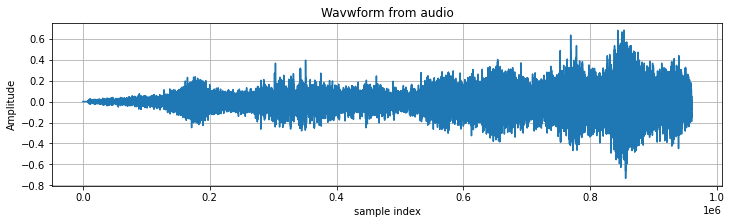

In [47]:
fig=plt.figure(figsize=(12,3))
plt.plot(snd_data[:20 * fs])
plt.xlabel('sample index')
plt.ylabel('Amplitude')
plt.title('Wavwform from audio')
plt.grid()

Calculate RMS sound pressure

$P_{RMS} = \sqrt{\frac{\sum_{dt} s_i^2} {n}}; dt = 0.1 sec;$

$SPL = 20 log_{10} \frac{P_{RMS}} {P_{ref}}$

$mSPL = min(SPL)_{dt}; dt = 1.1 sec$

In [32]:
wint = 0.1                                      # time window 0.1 s
wins = int(wint * fs)                           # time window width in index
n = snd_data.shape[0] // wins                   # number of time windows
p = snd_data[:wins * n].reshape((n, wins))      # change to 2D array
prms = np.sqrt(np.sum(np.square(p), axis=1) / wins)
tend = tstart + (prms.shape[0] -1) * wint       # end time in seconds from midnight
t = np.arange(tstart, tend, wint)

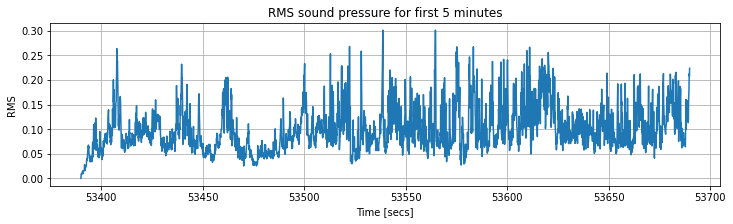

In [46]:
plt.figure(2, figsize=(12,3))
plt.plot(t[:int(300 // wint)], prms[:int(300 // wint)])
plt.xlabel('Time [secs]')
plt.ylabel('RMS')
plt.title('RMS sound pressure for first 5 minutes')
plt.grid()

In [26]:
pref = np.median(prms)
spl = 20 * np.log10(prms / pref)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Let's smooth data with moving median.

In [39]:
win2t = 1.1                     # moving window of 1.1 seconds
win2s = int(win2t // wint)
m = (win2s - 1) // 2
#mspl = np.array([np.median(spl[i-m:i+m]) for i in range(m, n-m-1)])
mspl = np.zeros(n)
for i in range(m, n - m - 1):
    mspl[i] = np.median(spl[i - m: i + m])

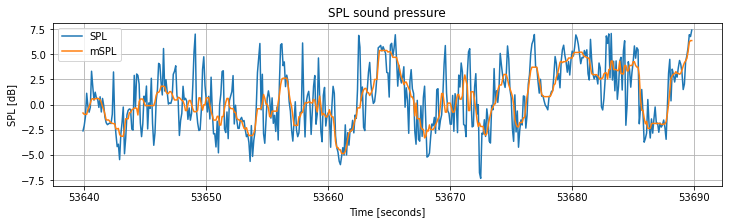

In [45]:
l1 = int(250 // wint)
l2 = int(300 // wint)              # length of plot in seconds
plt.figure(3, figsize=(12,3))
plt.plot(t[l1:l2], spl[l1:l2], label="SPL")
plt.plot(t[l1:l2], mspl[l1:l2], label="mSPL")
plt.xlabel('Time [seconds]')
plt.ylabel('SPL [dB]')
plt.title('SPL sound pressure')
plt.grid()
plt.legend()

33 seconds above critical


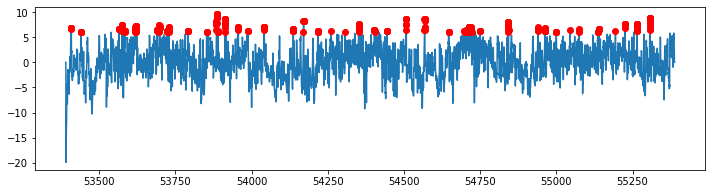

In [60]:
critical = 6
snd = np.c_[t, mspl]
snd_bus = snd[snd[:,1] > critical]
print(f'{snd_bus.shape[0] * wint:.0f} seconds above critical')
plt.figure(4, figsize=(12,3))
plt.plot(t, mspl)
plt.plot(snd_bus[:,0], snd_bus[:,1], 'ro')

In [64]:
start = 0                               # start row index of the first bus
sbus = []
for i in range(1, snd_bus.shape[0]):    # for each row except first
  if snd_bus[i,0] - snd_bus[i-1,0] > wint: # gap -> new bus arrived
    if i-start-1 > 2:                   # pass longer than 2 seconds?
      sbus.append((np.average(snd_bus[start:i,0]),
                  np.max(snd_bus[start:i,1]),
                  i-start-1))           # store time, max deflection and duration (sec)
    start = i
# add last
if snd_bus.shape[0] - start > wint:
  sbus.append((np.average(snd_bus[start:,0]),
              np.max(snd_bus[start:,1]),
              snd_bus.shape[0]-start))
print(f'{len(sbus)} busses found')
print(f'time  max.defl.  duration')
fo = open('sample_data/snd_bus.txt', 'w')
for b in sbus:
  print(f'{datetime.fromtimestamp(b[0]).strftime("%H:%M:%S"):8s} {b[1]:5.1f} {b[2]:5d}')
  print(f'{b[0]:.1f} {b[1]:.1f} {b[2]}', file=fo)
fo.close()

41 busses found
time  max.defl.  duration
14:50:07   6.9     5
14:50:39   6.1     4
14:52:44   6.7     4
14:52:55   7.5     9
14:53:03   6.3     4
14:53:37   7.0    10
14:53:40   7.3    10
14:54:49   6.4     5
14:54:57   7.4     7
14:55:21   6.3     5
14:55:28   7.0     4
14:56:30   6.3     4
14:58:05   9.6    14
14:58:32   8.6     9
14:59:16   7.0     8
15:00:40   7.1    10
15:02:16   6.6     6
15:02:50   8.3     6
15:03:37   6.3     6
15:05:51   7.6     8
15:06:42   6.5     5
15:07:24   6.2     4
15:08:27   8.7     7
15:09:27   8.7     8
15:10:46   6.1     3
15:11:39   6.3     3
15:11:42   6.4     4
15:11:46   6.1     4
15:11:53   7.1    12
15:11:59   7.0     5
15:12:30   6.2     4
15:14:02   8.1    11
15:15:40   7.1     6
15:16:03   6.8    13
15:16:39   6.0     3
15:17:54   6.6     5
15:18:56   6.1     4
15:19:00   6.6     5
15:20:25   7.7     5
15:21:04   7.7     9
15:21:47   8.9    10


## Find bus passes from video record of bus lane